<a href="https://colab.research.google.com/github/lovekittynine/Annotated-DDPM/blob/master/StableDiffusionInpaintPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 尝试stable diffusion inpaint pipeline

In [1]:
!pip3 install -Uq diffusers transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [1]:
# inpaint pipeline
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionPipeline
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torchvision
import requests
from io import BytesIO


In [2]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = Image.open(BytesIO(requests.get(img_url).content)).convert("RGB")
mask_image = Image.open(BytesIO(requests.get(mask_url).content)).convert("RGB")
down_scaled_mask = mask_image.resize((64, 64))

print(init_image.size)

(512, 512)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
inpaint_pipe = inpaint_pipe.to(device)

prompt = "a beautiful women, high resolution, sitting on a park bench"

image = inpaint_pipe(prompt, image=init_image, mask_image=mask_image).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

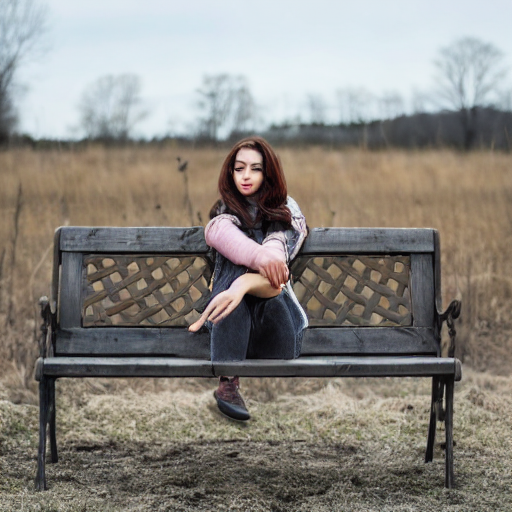

In [8]:
image

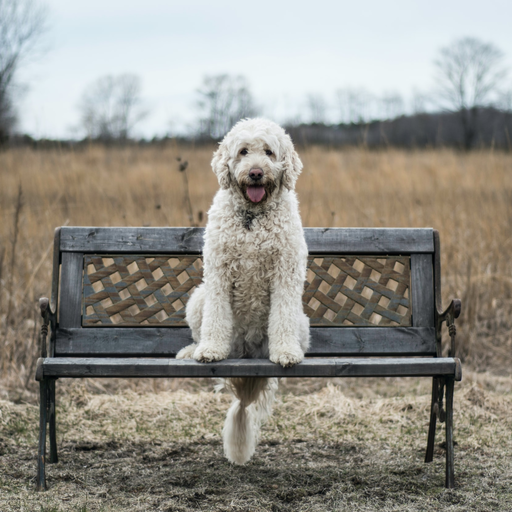

In [6]:
init_image

In [3]:
## 自定义逻辑简要实现inpaint pipeline
device = torch.device("cuda")
sd_pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")
sd_pipeline = sd_pipeline.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
init_image = torch.from_numpy(np.array(init_image)).permute([2,0,1]).unsqueeze(0)
# normalize [-1, 1]
init_image = init_image / 127.5 - 1.0
init_image = init_image.to(device)
mask_image = torch.from_numpy(np.array(mask_image)).permute([2,0,1]).unsqueeze(0)
mask_image = mask_image.to(device)
# 下采样的mask图像
down_scaled_mask = torch.from_numpy(np.array(down_scaled_mask)).permute([2,0,1]).unsqueeze(0)
down_scaled_mask = down_scaled_mask.to(device)
down_scaled_mask = down_scaled_mask / 255.0

In [5]:
from diffusers import DDIMScheduler
scheduler = DDIMScheduler.from_config(sd_pipeline.scheduler.config)
sd_pipeline.scheduler = scheduler

sd_pipeline.scheduler.set_timesteps(num_inference_steps=30)

In [6]:

with torch.inference_mode():

    # 获取输入图片的latents
    generator = torch.Generator(device).manual_seed(0)
    image_latents = sd_pipeline.vae.encode(init_image).latent_dist.sample(generator)
    image_latents *= sd_pipeline.vae.config.scaling_factor
    print(image_latents.shape)
    # random noise
    noise = torch.randn_like(image_latents)
    # 对输入进行加噪
    timesteps = sd_pipeline.scheduler.timesteps
    latents_input = sd_pipeline.scheduler.add_noise(image_latents, noise, timesteps[0])

    prompt = "a small robot, high resolution, sitting on a park bench"
    text_embeddings = sd_pipeline._encode_prompt(prompt, device, 1, True)

    # convert to 4 channel
    down_scaled_mask = torch.cat([down_scaled_mask, down_scaled_mask[:, :1, :, :]], dim=1)
    print(down_scaled_mask.shape)

    for i, t in enumerate(tqdm(timesteps)):
        # 做classifer free guidance
        latent_model_inputs = torch.cat([latents_input] * 2)
        # noise pred
        noise_pred = sd_pipeline.unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        # cfg
        noise_pred = noise_pred_uncond + 7.5*(noise_pred_text - noise_pred_uncond)
        # 获得t-1时刻去噪预测图
        latents_prev = sd_pipeline.scheduler.step(noise_pred, t, latents_input).prev_sample
        # 输入图像t-1时刻加噪图
        if i+1 < len(timesteps):
            latents_prev_img = sd_pipeline.scheduler.add_noise(image_latents, noise, timesteps[i+1])
        else:
            latents_prev_img = image_latents
        # mask区域以及非mask区域叠加
        latents_input = latents_prev_img * (1.0 - down_scaled_mask) + latents_prev * down_scaled_mask

        torch.cuda.empty_cache()

    image = sd_pipeline.decode_latents(latents_input.detach())

    sd_pipeline.numpy_to_pil(image)[0]




torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:429: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


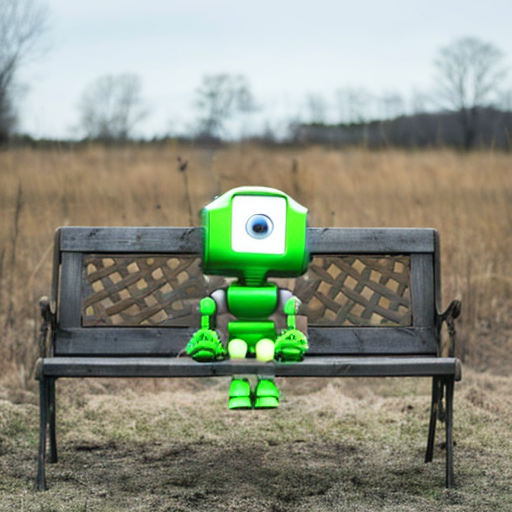

In [7]:
sd_pipeline.numpy_to_pil(image)[0]